In [1]:
from torch.nn import functional as F
from tqdm import tqdm
from pathlib import Path
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import to_networkx, from_networkx
import numpy as np
import random
from functools import partial
import torch_geometric.transforms as T
import networkx as nx

from torch_geometric.datasets import TUDataset

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

import torch

from torch.nn import functional as F
from tqdm import tqdm
from pathlib import Path

import argparse

import networkx as nx
import math
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

from torch_geometric.utils import (get_laplacian, to_scipy_sparse_matrix,
                                   to_undirected, to_dense_adj)
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.nn.models import GIN

/vol/bitbucket/jks17/miniconda3/envs/graphgps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
dataset = TUDataset('../', name='MUTAG')

In [16]:
model = GIN(dataset.num_features + 1, 32, 3, 32)


In [17]:
loss = torch.nn.L1Loss()

distances_random = []
distances_max = []
distances_min = []
cent = []

for data in dataset[:100]:
    v = torch.zeros(data.x.shape[0])
    x = torch.cat((data.x, v.unsqueeze(dim=1)), dim=1)
    
    v = torch.zeros(data.x.shape[0])
    G = to_networkx(data).to_undirected()
    centralities = torch.tensor(list(nx.subgraph_centrality(G).values()))
    rn = torch.argmax(centralities).item() 
    v[rn] = 1
    x_ce = torch.cat((data.x, v.unsqueeze(dim=1)), dim=1)
    
    v = torch.zeros(data.x.shape[0])
    rn = torch.argmin(centralities).item() 
    v[rn] = 1
    x_ce_min = torch.cat((data.x, v.unsqueeze(dim=1)), dim=1)
    
    v = torch.zeros(data.x.shape[0])
    rn = np.random.randint(len(v))
    v[rn] = 1
    x_random = torch.cat((data.x, v.unsqueeze(dim=1)), dim=1)

    op = model(x, data.edge_index)
    p = op.clone()
    op_ce = model(x_ce, data.edge_index) 
    op_ce_min = model(x_ce_min, data.edge_index) 
    op_random = model(x_random, data.edge_index)
    
    distances_max.append((op.sum(dim=0) - op_ce.sum(dim=0)).abs().mean().item())
    #distances_max.append(loss(((op + op_ce)/2), op).item())
    distances_min.append((op.sum(dim=0) - op_ce_min.sum(dim=0)).abs().mean().item())
    #distances_min.append(loss(((op + op_ce_min)/2), op).item())
    distances_random.append((op.sum(dim=0) - op_random.sum(dim=0)).abs().mean().item())
    #distances_random.append(loss(((op + op_random)/2), op).item())

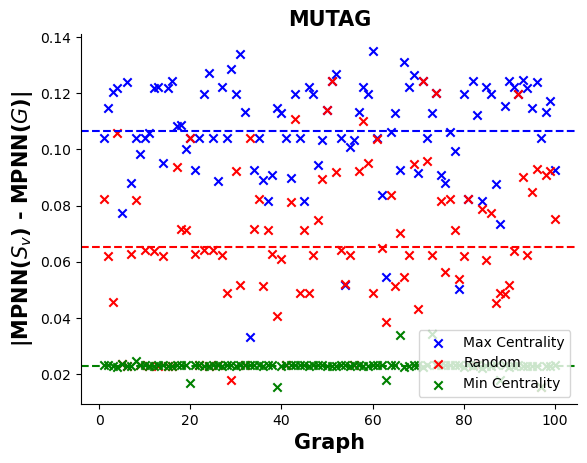

In [18]:
plt.scatter(np.arange(1, len(distances_max) + 1), distances_max, color = 'blue', marker = 'x', label = 'Max Centrality')
plt.scatter(np.arange(1, len(distances_random) + 1), distances_random, color='red', marker = 'x', label = 'Random')
plt.scatter(np.arange(1, len(distances_min) + 1), distances_min, color='green', marker = 'x', label = 'Min Centrality')
plt.xlabel('Graph', weight='bold', fontsize=15)
plt.ylabel("|MPNN($S_v$) - MPNN($G$)|", weight='bold', fontsize=15)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.legend(loc='lower right')
plt.title('MUTAG', weight='bold', fontsize=15)
plt.axhline(y = np.mean(distances_max), color = 'blue', linestyle = '--')
plt.axhline(y = np.mean(distances_random), color = 'red', linestyle = '--')
plt.axhline(y = np.mean(distances_min), color = 'green', linestyle = '--') 
plt.show()